# Signature detection from pretrained models

In [44]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from torchvision.models.detection.retinanet import RetinaNet_ResNet50_FPN_Weights
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF
from PIL import Image
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import cv2
import random

In [45]:
# torch.cuda.is_available = lambda: False

# check GPU
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))

CUDA available: True
Device: NVIDIA GeForce MX450


### Dataset

In [30]:
class MyDetectionDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None, max_size=800):
        self.images = []
        self.labels_dir = labels_dir
        self.transforms = transforms
        self.max_size = max_size

        # Filter out images without corresponding label files
        for img_path in sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]):
            base = os.path.splitext(os.path.basename(img_path))[0]
            lbl_path = os.path.join(labels_dir, base + '.txt')
            if os.path.exists(lbl_path) and os.path.getsize(lbl_path) > 0:  # Ensure label file is not empty
                self.images.append(img_path)
        
        random.shuffle(self.images)
        self.images = self.images[:50]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        # guard image opening and ensure grayscale -> RGB
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            raise RuntimeError(f'Failed to open image: {img_path} — {e}') from e
        orig_w, orig_h = img.size

        # resize to limit max side
        max_side = max(orig_w, orig_h)
        if self.max_size is not None and max_side > self.max_size:
            scale = self.max_size / float(max_side)
            new_w = int(round(orig_w * scale))
            new_h = int(round(orig_h * scale))
            img = img.resize((new_w, new_h), Image.BILINEAR)
        w, h = img.size

        base = os.path.splitext(os.path.basename(img_path))[0]
        lbl_path = os.path.join(self.labels_dir, base + '.txt')


        # Load boxes (scale them if image was resized)
        boxes = []
        labels = []
        if os.path.exists(lbl_path):
            with open(lbl_path) as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    x1, y1, w, h = map(float, line.split())
                    x2 = x1 + w
                    y2 = y1 + h
                    if scale != 1.0:
                        x1 *= scale
                        y1 *= scale
                        x2 *= scale
                        y2 *= scale
                    x1, x2, y1, y2 = int(x1), int(x2), int(y1), int(y2)
                    if x2 > x1 and y2 > y1:
                        boxes.append([x1, y1, x2, y2])
                        labels.append(1)
                    else:
                        print(f"Warning: Skipping invalid box {[x1, y1, x2, y2]} in {lbl_path}")

        boxes = torch.as_tensor(boxes, dtype=torch.int64) if boxes else torch.zeros((0,4), dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)
        image_id = torch.tensor([idx], dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if boxes.size(0) > 0 else torch.tensor([], dtype=torch.float32)
        iscrowd = torch.zeros((boxes.size(0),), dtype=torch.int64) if boxes.size(0) > 0 else torch.zeros((0,), dtype=torch.int64)
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        img_tensor = TF.to_tensor(img)
        if self.transforms:
            img_tensor, target = self.transforms(img_tensor, target)
        return img_tensor, target

### Hyperparameters

In [46]:
train_images = "datasets/custom_dataset_augmented/images/train"
val_images = "datasets/custom_dataset_augmented/images/val"
train_labels = "datasets/custom_dataset_augmented/labels/train"
val_labels = "datasets/custom_dataset_augmented/labels/val"

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (signature) + background
imgsz = 512
epochs = 10
batch_size = 4
learning_rate = 0.005

### utility functions

In [4]:
def iou(boxA, boxB):
    # boxes are [x1,y1,x2,y2]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    boxAArea = max(0, (boxA[2] - boxA[0])) * max(0, (boxA[3] - boxA[1]))
    boxBArea = max(0, (boxB[2] - boxB[0])) * max(0, (boxB[3] - boxB[1]))
    denom = float(boxAArea + boxBArea - interArea)
    return interArea / denom if denom > 0 else 0.0

In [5]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    it = 0
    for images, targets in loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        running_loss += losses.item()
        it += 1
    return running_loss / max(1, it)

In [6]:
def validate(model, loader, device):
    model.train()
    val_loss = 0.0
    it = 0

    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Temporarily run in train mode to get loss dict (model() in eval returns list)
            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
            it += 1

    return val_loss / max(1, it)


In [7]:
def evaluate_precision_recall(model, loader, device, iou_th=0.5, score_th=0.5):
    model.eval()
    TP = 0
    FP = 0
    FN = 0
    with torch.no_grad():
        for images, targets in loader:
            img = images[0].to(device)
            gt = targets[0]
            preds = model([img])[0]
            pred_boxes = preds['boxes'].cpu().numpy()
            pred_scores = preds['scores'].cpu().numpy()
            gt_boxes = gt['boxes'].cpu().numpy() if gt['boxes'].size(0) > 0 else np.zeros((0,4))

            keep_idx = np.where(pred_scores >= score_th)[0]
            pred_boxes = pred_boxes[keep_idx]
            matched_gt = set()
            for pb in pred_boxes:
                best_iou = 0
                best_j = -1
                for j, gb in enumerate(gt_boxes):
                    if j in matched_gt:
                        continue
                    cur_iou = iou(pb, gb)
                    if cur_iou > best_iou:
                        best_iou = cur_iou
                        best_j = j
                if best_iou >= iou_th and best_j >= 0:
                    TP += 1
                    matched_gt.add(best_j)
                else:
                    FP += 1
            FN += (len(gt_boxes) - len(matched_gt))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    return precision, recall


In [8]:
def training_loop(model, train_loader, val_loader, optimizer, lr_scheduler, device, epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        t0 = time.time()
        try:
            train_loss = train_one_epoch(model, train_loader, optimizer, device)
            lr_scheduler.step()
            val_loss = validate(model, val_loader, device)
            prec, rec = evaluate_precision_recall(model, val_loader, device)
            print(f'Epoch {epoch+1}/{epochs} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, prec: {prec:.3f}, rec: {rec:.3f}, time: {time.time()-t0:.1f}s')
            train_losses.append(train_loss)
            val_losses.append(val_loss)
        except RuntimeError as e:
            if 'out of memory' in str(e).lower():
                print('RuntimeError: CUDA out of memory during training.\nConsider:')
                # try to free cache and continue or abort
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                raise
            else:
                raise
    return model, train_losses, val_losses

## Training for different architectures

### Fast R-CNN - resnet

In [ ]:
train_ds = MyDetectionDataset(train_images, train_labels, max_size=512)
val_ds = MyDetectionDataset(val_images, val_labels, max_size=512)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

frcnn_resnet_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)
in_features = frcnn_resnet_model.roi_heads.box_predictor.cls_score.in_features
frcnn_resnet_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

try:
    frcnn_resnet_model.to(device)
except RuntimeError as e:
    print('Error moving model to device — falling back to CPU.\n', e)
    device = torch.device('cpu')
    frcnn_resnet_model.to(device)

# clear cache and reduce fragmentation
if torch.cuda.is_available():
    torch.cuda.empty_cache()

params = [p for p in frcnn_resnet_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print("Starting training...")
frcnn_resnet_model, frcnn_resnet_train_losses, frcnn_resnet_val_losses \
    = training_loop(frcnn_resnet_model, train_loader, val_loader, optimizer, lr_scheduler, device, epochs)

Starting training...


### Fast R-CNN - mobilenet

In [47]:
train_ds = MyDetectionDataset(train_images, train_labels, max_size=512)
val_ds = MyDetectionDataset(val_images, val_labels, max_size=512)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

frcnn_mobilenet_model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=True)
in_features = frcnn_mobilenet_model.roi_heads.box_predictor.cls_score.in_features
frcnn_mobilenet_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

try:
    frcnn_mobilenet_model.to(device)
except RuntimeError as e:
    print('Error moving model to device — falling back to CPU.\n', e)
    device = torch.device('cpu')
    frcnn_mobilenet_model.to(device)

# clear cache and reduce fragmentation
if torch.cuda.is_available():
    torch.cuda.empty_cache()

params = [p for p in frcnn_mobilenet_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print("Starting training...")
frcnn_mobilenet_model, frcnn_mobilenet_train_losses, frcnn_mobilenet_val_losses \
    = training_loop(frcnn_mobilenet_model, train_loader, val_loader, optimizer, lr_scheduler, device, epochs)

### RetinaNet

In [11]:
train_ds = MyDetectionDataset(train_images, train_labels, max_size=512)
val_ds = MyDetectionDataset(val_images, val_labels, max_size=512)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

retinanet_model = torchvision.models.detection.retinanet_resnet50_fpn(weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT)
in_features = retinanet_model.head.classification_head.conv[0][0].in_channels
num_anchors = retinanet_model.head.classification_head.num_anchors
retinanet_model.head.classification_head = RetinaNetClassificationHead(in_features, num_anchors, 2)

try:
    retinanet_model.to(device)
except RuntimeError as e:
    print('Error moving model to device — falling back to CPU.\n', e)
    device = torch.device('cpu')
    retinanet_model.to(device)

# clear cache and reduce fragmentation
if torch.cuda.is_available():
    torch.cuda.empty_cache()

params = [p for p in retinanet_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [12]:
print("Starting training...")
retinanet_model, retinanet_train_losses, retinanet_val_losses \
    = training_loop(retinanet_model, train_loader, val_loader, optimizer, lr_scheduler, device, epochs)

Starting training...
Epoch 1/10 — train_loss: 1.6515, val_loss: 1.3018, prec: 0.000, rec: 0.000, time: 57.5s
Epoch 2/10 — train_loss: 1.6427, val_loss: 1.7344, prec: 0.000, rec: 0.000, time: 56.7s
Epoch 3/10 — train_loss: 1.5357, val_loss: 1.5019, prec: 0.000, rec: 0.000, time: 56.9s
Epoch 4/10 — train_loss: 1.4325, val_loss: 1.4510, prec: 0.000, rec: 0.000, time: 56.9s
Epoch 5/10 — train_loss: 1.3413, val_loss: 1.4351, prec: 0.000, rec: 0.000, time: 57.0s
Epoch 6/10 — train_loss: 1.2906, val_loss: 1.4355, prec: 0.000, rec: 0.000, time: 56.9s
Epoch 7/10 — train_loss: 1.2551, val_loss: 1.4264, prec: 0.000, rec: 0.000, time: 57.0s
Epoch 8/10 — train_loss: 1.2435, val_loss: 1.4208, prec: 0.000, rec: 0.000, time: 56.9s
Epoch 9/10 — train_loss: 1.2356, val_loss: 1.4119, prec: 0.000, rec: 0.000, time: 57.0s
Epoch 10/10 — train_loss: 1.2290, val_loss: 1.4112, prec: 0.000, rec: 0.000, time: 57.0s


## Evaluation

In [36]:
model = frcnn_mobilenet_model
train_losses = frcnn_mobilenet_train_losses
val_losses = frcnn_mobilenet_val_losses

NameError: name 'frcnn_mobilenet_train_losses' is not defined

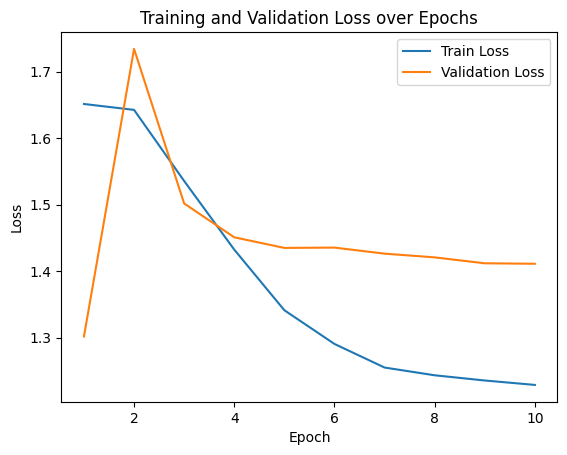

In [14]:
# plot training/validation loss curves
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
torch.save(model, './models/weights/retinanet_10e.pt')

## Inference

In [50]:
model = frcnn_mobilenet_model
model = torch.load('./models/weights/mobilenet_10e_augmented.pt', weights_only=False)

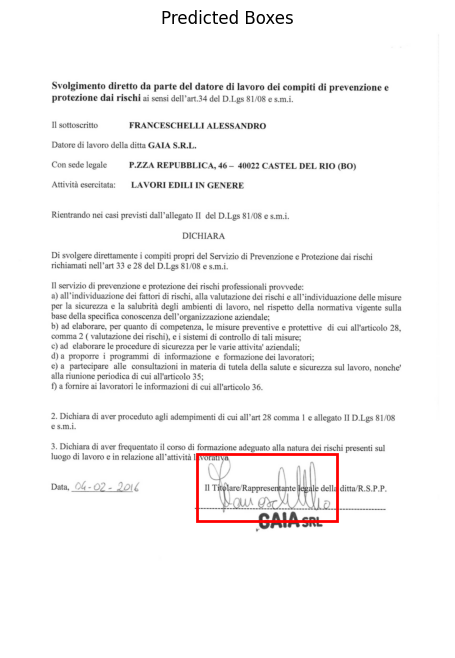

In [57]:
inf_img_path = 'datasets/snps/imgs/3_001.png'
img = cv2.imread(inf_img_path)
model.eval()

# Convert image to RGB and tensor
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
from torchvision.transforms import ToTensor
img_tensor = ToTensor()(img_rgb).to(device)

with torch.no_grad():
    preds = model([img_tensor])[0]
pred_boxes = preds['boxes'].cpu().numpy()
pred_scores = preds['scores'].cpu().numpy()

# Filter boxes by score threshold
score_th = 0.5
keep = pred_scores >= score_th
pred_boxes = pred_boxes[keep]

# Plot image and predicted boxes
plt.figure(figsize=(8,8))
plt.imshow(img_rgb)
ax = plt.gca()
for box in pred_boxes:
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2)
    ax.add_patch(rect)
plt.title('Predicted Boxes')
plt.axis('off')
plt.show()

In [ ]:

# model.eval()
# n = 5
# plt.figure(figsize=(12,4*n))
# cnt = 1
# with torch.no_grad():
#     for i in range(min(n, len(val_ds))):
#         img_tensor, target = val_ds[i]
#         img = img_tensor.to(device)
#         preds = model([img])[0]
#         pred_boxes = preds['boxes'].cpu().numpy()
#         pred_scores = preds['scores'].cpu().numpy()
#         keep = pred_scores >= 0.5
#         pred_boxes = pred_boxes[keep]
#         gt_boxes = target['boxes'].numpy() if target['boxes'].size(0) > 0 else np.zeros((0,4))

#         vis_pred = draw_boxes(img_tensor, pred_boxes, color=(0,0,255))
#         vis_gt = draw_boxes(img_tensor, gt_boxes, color=(0,255,0))
#         # combine side-by-side
#         combined = np.concatenate([vis_gt, vis_pred], axis=1)
#         plt.subplot(n,1,cnt); plt.axis('off'); plt.title(f'Left=GT Right=Pred (i={i})'); plt.imshow(combined[:,:,::-1])
#         cnt += 1
# plt.show()